# Notebook of comparison VAE and geometric VAE

In [26]:
import numpy as np
import pandas as pd
import scanpy as sc

from scCFM.models.base.vae import VAE
from scCFM.models.base.geometric_vae import GeometricNBVAE, GeometricNBAE
from scCFM.models.base.geodesic_ae import GeodesicAE

from scCFM.datamodules.sc_datamodule import scDataModule

from scCFM.models.manifold.geometry_metrics import compute_all_metrics

import sys
sys.path.insert(0, "../..")
from notebooks.utils import real_reconstructed_cells_adata

from paths import PROJECT_FOLDER
import torch
import anndata

import scipy

import seaborn as sns

**Util functions**

In [27]:
def make_joint_df(arrays, labels):
    all_arrays = np.concatenate(arrays)
    all_labels = []
    for i,lab in enumerate(labels):
        all_labels += [lab for _ in range(len(arrays[i]))]
    return pd.DataFrame({"values": all_arrays,
                         "labels": all_labels})

## Initialize the two different configurations 

General module hparams

In [28]:
datamodule={'path': PROJECT_FOLDER / 'data/pancreas/processed/pancreas.h5ad', 
            'x_layer': 'X_norm', 
            'cond_keys': ['experimental_time', 'celltype'],
            'use_pca': False, 
            'n_dimensions': None, 
            'train_val_test_split': [1], 
            'batch_size': 128, 
            'num_workers': 2}


# Initialize datamodule
datamodule = scDataModule(**datamodule)

In [29]:
adata = sc.read_h5ad(PROJECT_FOLDER / 'data/pancreas/processed/pancreas.h5ad')

In [30]:
dict(zip(range(17), np.unique(adata.obs.celltype)))

{0: 'Acinar',
 1: 'Alpha',
 2: 'Beta',
 3: 'Delta',
 4: 'Ductal',
 5: 'Epsilon',
 6: 'Fev+ Alpha',
 7: 'Fev+ Beta',
 8: 'Fev+ Delta',
 9: 'Fev+ Epsilon',
 10: 'Fev+ Pyy',
 11: 'Multipotent',
 12: 'Ngn3 High early',
 13: 'Ngn3 High late',
 14: 'Ngn3 low EP',
 15: 'Tip',
 16: 'Trunk'}

### Model config VAE

In [31]:
model_vae={
       'in_dim': datamodule.in_dim,
       'n_epochs_anneal_kl': 1000, 
       'kl_weight': None, 
       'likelihood': 'nb', 
       'dropout': False, 
       'learning_rate': 0.001, 
       'dropout_p': False, 
       'model_library_size': True, 
       'batch_norm': True, 
       'kl_warmup_fraction': 0.1, 
       'hidden_dims': [256, 30]}
        
geometric={'compute_metrics_every': 1, 
           'use_c': True, 
           'l2': True, 
           'eta_interp': 0, 
           'interpolate_z': False, 
           'start_jac_after' : 0, 
           'fl_weight': 0.1,
           'detach_theta': True}

geodesic={"in_dim": datamodule.in_dim,
          "hidden_dims": [256, 30],
          "batch_norm": True,
          "dropout": False, 
          "dropout_p": False,
          "likelihood": "nb",
          "learning_rate": 0.001}

In [32]:
vae = GeometricNBVAE(**geometric, vae_kwargs=model_vae).eval()
geometric_vae = GeometricNBVAE(**geometric, vae_kwargs=model_vae).eval()
geodesic_ae = GeodesicAE(**geodesic)

In [33]:
# vae = GeometricNBAE(**geometric, vae_kwargs=model_ae)
# geometric_vae = GeometricNBAE(**geometric, vae_kwargs=model_ae)

In [34]:
vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/pancreas/best_model_vae_lib_30.ckpt")["state_dict"])
geometric_vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/pancreas/best_model_geometric_lib_30_2.ckpt")["state_dict"])
geodesic_ae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/pancreas/best_model_geodesic_ae_30.ckpt")["state_dict"])

<All keys matched successfully>

### Compute UMAPs

In [35]:
# adata_vae_amortized_real, adata_vae_z, adata_vae_mu = real_reconstructed_cells_adata(vae, datamodule, process_amortized_adata=True, log1p=False, vae=True).values()
adata_geometric_amortized_real, adata_geometric_z, adata_geometric_mu = real_reconstructed_cells_adata(geometric_vae, datamodule, process_amortized_adata=True, log1p=False, vae=True).values()
# adata_geodesic_amortized_real, adata_geodesic_z, adata_geodesic_mu = real_reconstructed_cells_adata(geodesic_ae, datamodule, process_amortized_adata=True, log1p=False, vae=False, model_type="geodesic").values()

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [36]:
# adata_vae_z.obs["celltype"] = adata_vae_z.obs["celltype"].astype("category")
adata_geometric_z.obs["celltype"] = adata_geometric_z.obs["celltype"].astype("category")
# adata_geodesic_z.obs["celltype"] = adata_geodesic_z.obs["celltype"].astype("category")

Plot the UMAP results

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


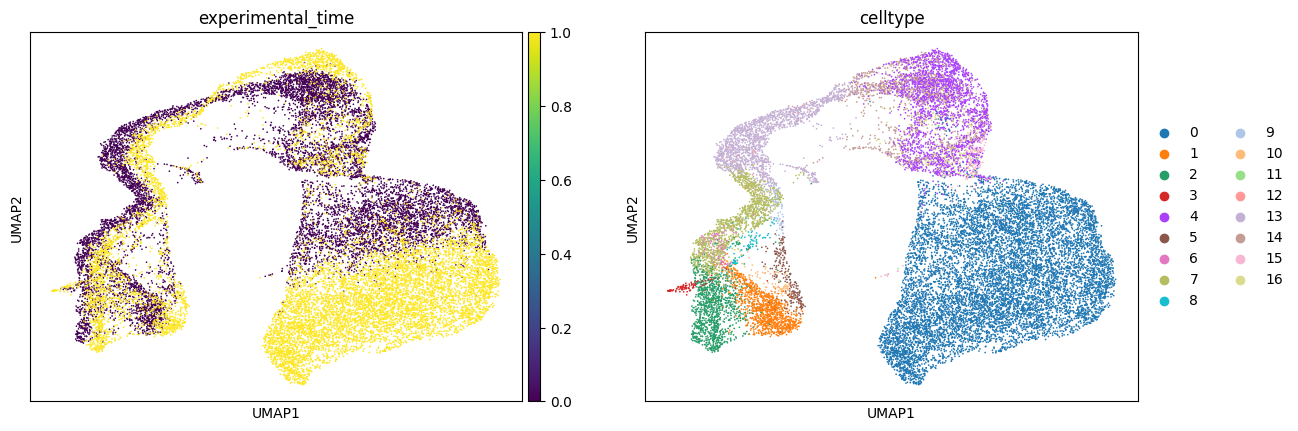

In [37]:
# sc.pl.umap(adata_vae_z, color=["experimental_time", "celltype"])
sc.pl.umap(adata_geometric_z, color=["experimental_time", "celltype"])
# sc.pl.umap(adata_geodesic_z, color=["experimental_time", "celltype"])

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


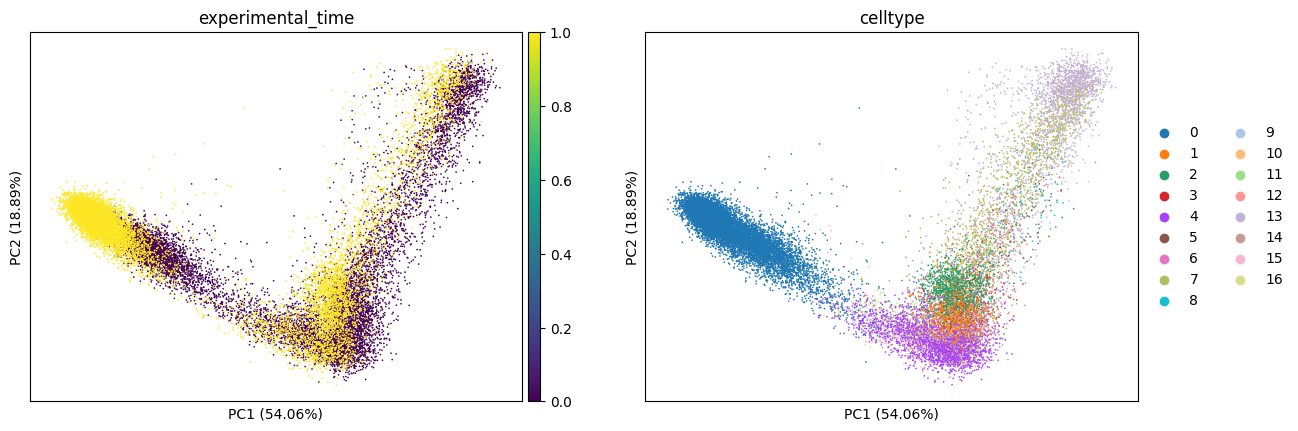

In [38]:
# sc.pl.pca(adata_vae_z, color=["experimental_time", "celltype"], annotate_var_explained=True)
sc.pl.pca(adata_geometric_z, color=["experimental_time", "celltype"], annotate_var_explained=True)
# sc.pl.pca(adata_geodesic_z, color=["experimental_time", "celltype"], annotate_var_explained=True)

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


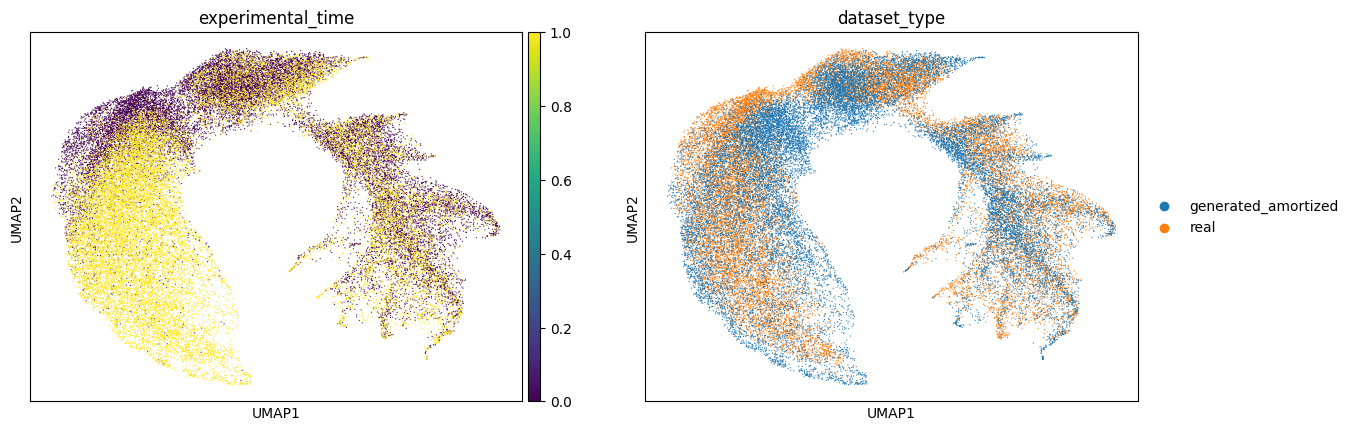

In [39]:
# sc.pl.umap(adata_vae_amortized_real, color=["experimental_time", "dataset_type"])
sc.pl.umap(adata_geometric_amortized_real, color=["experimental_time", "dataset_type"])
# sc.pl.umap(adata_geodesic_amortized_real, color=["experimental_time", "dataset_type"])

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


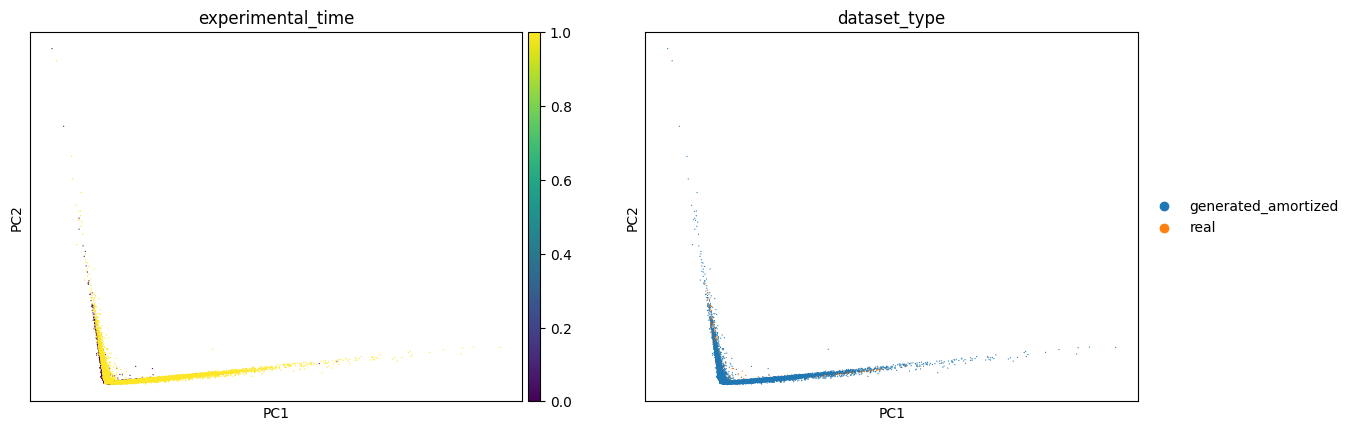

In [40]:
# sc.pl.pca(adata_vae_amortized_real, color=["experimental_time", "dataset_type"])
sc.pl.pca(adata_geometric_amortized_real, color=["experimental_time", "dataset_type"])
# sc.pl.pca(adata_geodesic_amortized_real, color=["experimental_time", "dataset_type"])

Check reconstruction umap

**Save anndata**

In [43]:
# adata_vae_z.layers["X_latents"] = adata_vae_z.X.copy()
# adata_vae_z.write_h5ad(PROJECT_FOLDER / "data/pancreas/flat/pancreas_lib_30.h5ad")

In [42]:
adata_geometric_z.layers["X_latents"] = adata_geometric_z.X.copy()
adata_geometric_z.write_h5ad(PROJECT_FOLDER / "data/pancreas/flat/pancreas_flat_lib_30_2.h5ad")

In [45]:
# adata_geodesic_z.layers["X_latents"] = adata_geodesic_z.X.copy()
# adata_geodesic_z.write_h5ad(PROJECT_FOLDER / "data/pancreas/flat/pancreas_geodesic_lib_30.h5ad")

In [ ]:
# python train_cfm.py --multirun hydra=CFM_schiebinger_flat_leaveout datamodule=CFM_schiebinger_flat_leaveout logger=CFM_schiebinger_flat_leaveout train=CFM_schiebinger_flat_leaveout
# python train_cfm.py --multirun hydra=CFM_schiebinger_geodesic_leaveout datamodule=CFM_schiebinger_geodesic_leaveout logger=CFM_schiebinger_geodesic_leaveout train=CFM_schiebinger_geodesic_leaveout
# python train_cfm.py --multirun hydra=CFM_schiebinger_leaveout datamodule=CFM_schiebinger_leaveout logger=CFM_schiebinger_leaveout train=CFM_schiebinger_leaveout 